In [4]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, decimate

In [ ]:
# ===== SESSION SELECTION =====
SESSION = "a3"         # animal id
STIM = "pinch_contra"  # stim type
# =============================

# Load table (prefer local override if present)
table_path = Path("data/sessions_local.csv") if Path("data/sessions_local.csv").exists() else Path("data/sessions.csv")
sessions = pd.read_csv(table_path, sep='\t')  # your CSV is tab-delimited

# Select row by session + stim
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]
if row.empty:
    raise ValueError(f"No row found for session={SESSION}, stim={STIM}")

row = row.iloc[0]

# Extract paths and metadata
phy_dir = Path(row['phy_dir']) if pd.notna(row['phy_dir']) and row['phy_dir'].strip() else None
ap_dir  = Path(row['ap_dir']) if pd.notna(row['ap_dir']) and row['ap_dir'].strip() else None
age = str(row['age']).strip() if pd.notna(row['age']) else "unknown"
notes = str(row['notes']).strip() if pd.notna(row['notes']) else ""

# Anatomy bands
S1_upper_um  = float(row['s1_upper_um'])
S1_lower_um  = float(row['s1_lower_um'])
VPL_upper_um = float(row['vpl_upper_um'])
VPL_lower_um = float(row['vpl_lower_um'])



# Sanity check
if phy_dir is None or not phy_dir.exists():
    print(f"⚠️ Warning: phy_dir not found or empty for {SESSION}/{STIM}. Check paths or notes: '{notes}'")
if ap_dir is None or not ap_dir.exists():
    print(f"⚠️ Warning: ap_dir not found or empty for {SESSION}/{STIM}. Check paths.")

print(f"Loaded: {SESSION} / {STIM} (age: {age})")
print(f"Notes: {notes}")
print(f"phy_dir: {phy_dir}")
print(f"ap_dir:  {ap_dir}")

Loaded: a3 / pinch_contra (age: adult)
Notes: Sprase?
phy_dir: C:\Users\Ben\Desktop\Contra Pinch\A3
ap_dir:  E:\Neurpixels_Sally\practice3_SZMB_jawpinch_contra_final_2024-11-21_16-13-07\Record Node 118\experiment1\recording1\continuous\Neuropix-PXI-117.ProbeA-AP


In [7]:
# Core arrays
spike_times = np.load(phy_dir/'spike_times.npy')                 # (n_spikes,) in samples
spike_clusters = np.load(phy_dir/'spike_clusters.npy')           # (n_spikes,)
spike_positions = np.load(phy_dir/'spike_positions.npy')         # (n_spikes, 2) columns ~ [x_um, y_um]
channel_positions = np.load(phy_dir/'channel_positions.npy')     # (n_channels, 2)
channel_map = np.load(phy_dir/'channel_map.npy')                 # (n_channels,)
templates = np.load(phy_dir/'templates.npy')                     # (n_templates, t, n_channels)
spike_templates = np.load(phy_dir/'spike_templates.npy')         # (n_spikes,)
params_txt = (phy_dir/'params.py').read_text()



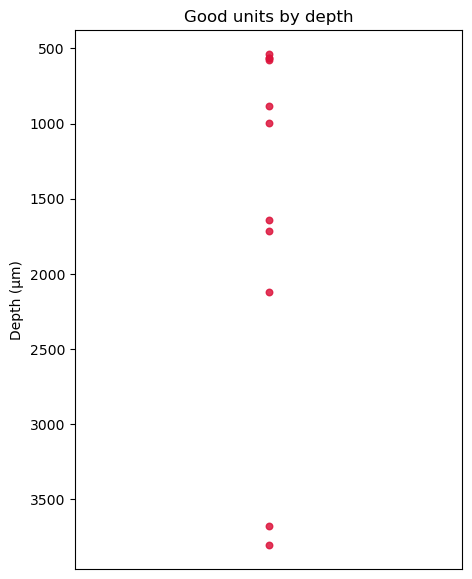

In [8]:


# Sample rate from params.py (fallback 30000)
def parse_sample_rate(params_path):
    sr = 30000.0
    try:
        txt = params_path.read_text()
        if 'sample_rate' in txt:
            for line in txt.splitlines():
                if 'sample_rate' in line and '=' in line:
                    sr = float(line.split('=')[-1]); break
        elif 'ops' in txt and 'fs' in txt:
            import ast
            start = txt.find('{'); end = txt.rfind('}')
            dct = ast.literal_eval(txt[start:end+1])
            if 'fs' in dct: sr = float(dct['fs'])
    except Exception:
        pass
    return sr

sample_rate = parse_sample_rate(phy_dir/'params.py')
spike_times_s = spike_times.astype(np.float64) / sample_rate

# Load curation labels
# Prefer cluster_info.tsv; fallback to cluster_group.tsv
cluster_info_path = None
for p in ["cluster_info.tsv", "clusters.phy/cluster_info.tsv", "cluster_group.tsv"]:
    if (phy_dir/p).exists():
        cluster_info_path = phy_dir/p; break

if cluster_info_path is None:
    unique_cids = np.unique(spike_clusters)
    cluster_df = pd.DataFrame({'id': unique_cids, 'group': 'unsorted'})
else:
    cluster_df = pd.read_csv(cluster_info_path, sep='\t')
    if 'cluster_id' in cluster_df.columns and 'id' not in cluster_df.columns:
        cluster_df = cluster_df.rename(columns={'cluster_id':'id'})
    if 'group' not in cluster_df.columns:
        for alt in ['KSLabel','ks_label','label']:
            if alt in cluster_df.columns:
                cluster_df['group'] = cluster_df[alt]; break
        if 'group' not in cluster_df.columns:
            cluster_df['group'] = 'unsorted'

# Select "good" units by label
good_ids = cluster_df.query("group in ['good','accepted','pass','Good','Accepted']").id.to_numpy()

# Compute unit depths
# Strategy: per cluster, take median y from spike_positions of spikes belonging to that cluster (robust and independent of templates)
cluster_depths = {}
for cid in good_ids:
    idx = (spike_clusters == cid)
    if np.any(idx):
        y = spike_positions[idx, 1]
        cluster_depths[int(cid)] = float(np.median(y))
    else:
        cluster_depths[int(cid)] = np.nan

cluster_df['depth_est'] = cluster_df['id'].map(lambda cid: cluster_depths.get(int(cid), np.nan))
good_df = cluster_df[cluster_df['id'].isin(good_ids)].copy()

# Plot "good" unit depths
plt.figure(figsize=(5,7))
y = good_df['depth_est'].to_numpy()
plt.scatter(np.zeros_like(y), y, s=22, c='crimson', alpha=0.85)
plt.gca().invert_yaxis()
plt.xticks([])
plt.ylabel('Depth (µm)')
plt.title('Good units by depth')
plt.show()



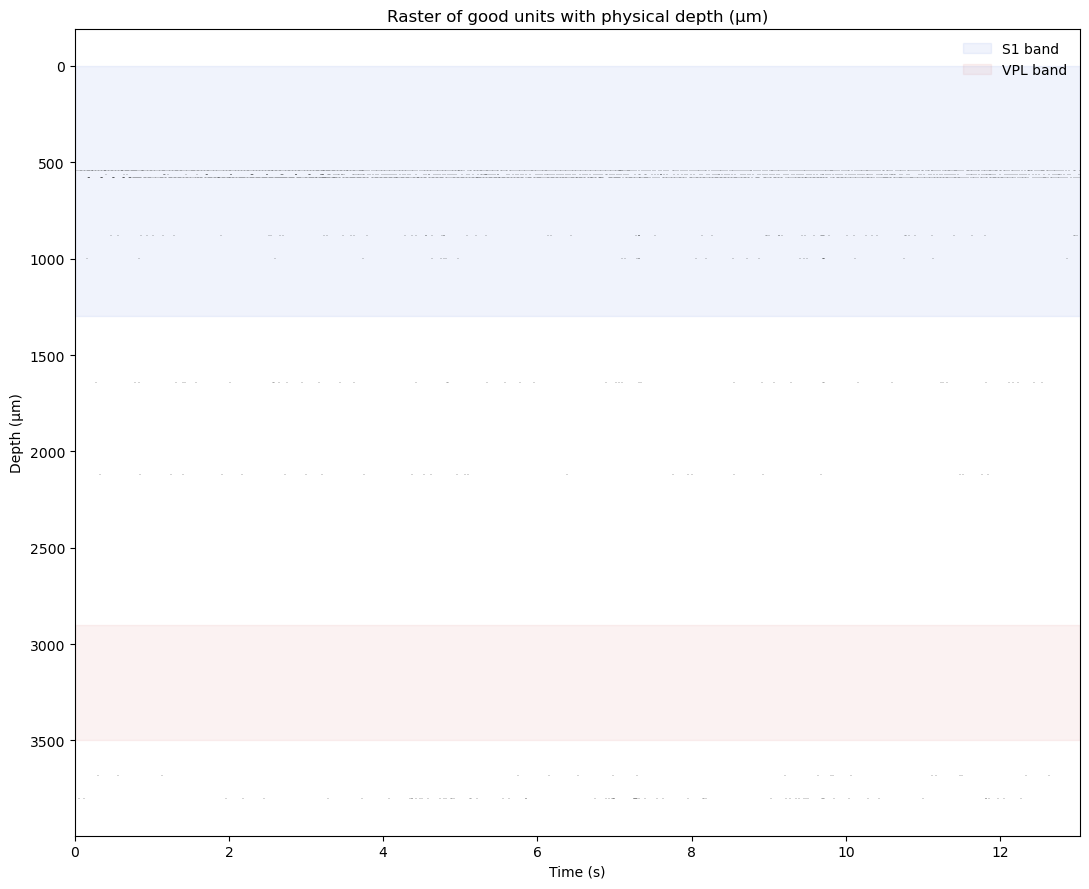

In [9]:

# Sample rate
def parse_sample_rate(txt):
    sr = 30000.0
    try:
        if 'sample_rate' in txt:
            for line in txt.splitlines():
                if 'sample_rate' in line and '=' in line:
                    sr = float(line.split('=')[-1]); break
        elif 'ops' in txt and 'fs' in txt:
            import ast
            start = txt.find('{'); end = txt.rfind('}')
            dct = ast.literal_eval(txt[start:end+1])
            if 'fs' in dct: sr = float(dct['fs'])
    except Exception:
        pass
    return sr

sample_rate = parse_sample_rate(params_txt)
spike_times_s = spike_times.astype(np.float64) / sample_rate

# Curation labels
cluster_info_path = phy_dir/'cluster_info.tsv' if (phy_dir/'cluster_info.tsv').exists() else (
    phy_dir/'clusters.phy/cluster_info.tsv' if (phy_dir/'clusters.phy/cluster_info.tsv').exists() else phy_dir/'cluster_group.tsv'
)
if cluster_info_path.exists():
    cluster_df = pd.read_csv(cluster_info_path, sep='\t')
    if 'cluster_id' in cluster_df.columns and 'id' not in cluster_df.columns:
        cluster_df = cluster_df.rename(columns={'cluster_id':'id'})
    if 'group' not in cluster_df.columns:
        for alt in ['KSLabel','ks_label','label']:
            if alt in cluster_df.columns:
                cluster_df['group'] = cluster_df[alt]; break
        if 'group' not in cluster_df.columns:
            cluster_df['group'] = 'unsorted'
else:
    unique_cids = np.unique(spike_clusters)
    cluster_df = pd.DataFrame({'id': unique_cids, 'group': 'unsorted'})

good_ids = cluster_df.query("group in ['good','accepted','pass','Good','Accepted']").id.to_numpy().astype(int)

# Median depth per unit (µm) from spike_positions
unit_depth_um = {}
for cid in good_ids:
    idx = (spike_clusters == cid)
    if idx.any():
        unit_depth_um[cid] = float(np.median(spike_positions[idx, 1]))
    else:
        unit_depth_um[cid] = np.nan

# Prepare data for plotting
# Sort units by depth (shallow to deep)
good_depths = np.array([unit_depth_um[cid] for cid in good_ids])
order = np.argsort(good_depths)
good_ids_sorted = good_ids[order]
good_depths_sorted = good_depths[order]

# Full-session raster with y = µm
tmin = 0.0
tmax = float(np.nanmax(spike_times_s)) if spike_times_s.size else 0.0

fig, ax = plt.subplots(figsize=(11,9))

for cid, depth in zip(good_ids_sorted, good_depths_sorted):
    if np.isnan(depth): 
        continue
    ts = spike_times_s[spike_clusters == cid]
    if ts.size:
        # draw very thin lines at y=depth for all spikes in this unit
        ax.vlines(ts, depth-2, depth+2, color='k', linewidth=0.25)  # 4 µm tick per spike; adjust thickness as preferred

# Optional: shade anatomical bands if known (fill in your ranges)
# Example placeholders:
S1_upper_um, S1_lower_um = 0, 1300
VPL_upper_um, VPL_lower_um = 2900, 3500
ax.axhspan(S1_upper_um, S1_lower_um, color='royalblue', alpha=0.08, label='S1 band')
ax.axhspan(VPL_upper_um, VPL_lower_um, color='indianred', alpha=0.08, label='VPL band')
ax.legend(loc='upper right', frameon=False)

ax.invert_yaxis()
ax.set_xlim(tmin, tmax)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Depth (µm)')
ax.set_title('Raster of good units with physical depth (µm)')
plt.tight_layout()
plt.show()

# Zoom helper with µm y-axis
def plot_depth_raster_window(t0, twin=20.0):
    t1 = t0 + twin
    fig, ax = plt.subplots(figsize=(11,6))
    for cid, depth in zip(good_ids_sorted, good_depths_sorted):
        if np.isnan(depth): 
            continue
        ts = spike_times_s[spike_clusters == cid]
        sel = (ts>=t0)&(ts<=t1)
        if sel.any():
            ax.vlines(ts[sel], depth-3, depth+3, color='k', linewidth=0.6)
    ax.axhspan(S1_upper_um, S1_lower_um, color='royalblue', alpha=0.08)
    ax.axhspan(VPL_upper_um, VPL_lower_um, color='indianred', alpha=0.08)
    ax.invert_yaxis()
    ax.set_xlim(t0, t1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Depth (µm)')
    ax.set_title(f'Raster window (µm y-axis): {t0:.1f}–{t1:.1f} s')
    plt.tight_layout()
    plt.show()

# Examples:
# plot_depth_raster_window(0, 30)
# plot_depth_raster_window(60, 30)

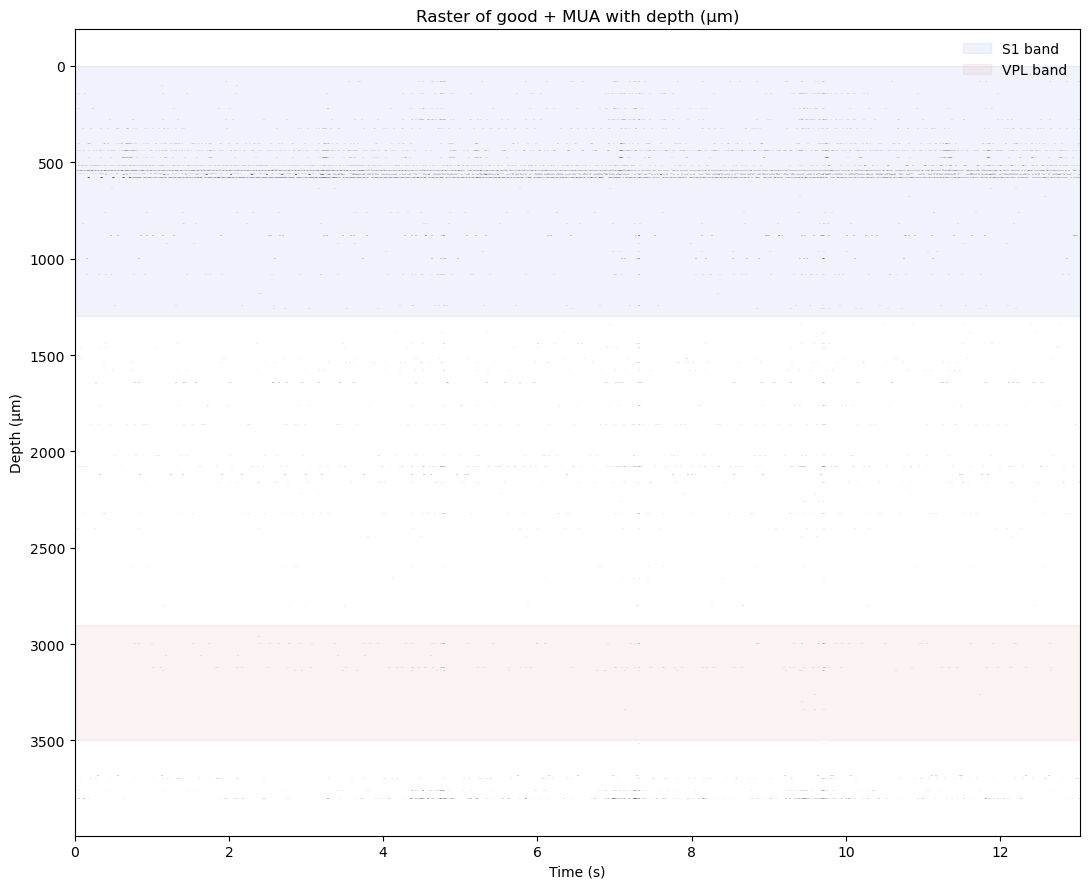

In [10]:

# Sample rate
def parse_sample_rate(txt):
    sr = 30000.0
    try:
        if 'sample_rate' in txt:
            for line in txt.splitlines():
                if 'sample_rate' in line and '=' in line:
                    sr = float(line.split('=')[-1]); break
        elif 'ops' in txt and 'fs' in txt:
            import ast
            start = txt.find('{'); end = txt.rfind('}')
            dct = ast.literal_eval(txt[start:end+1])
            if 'fs' in dct: sr = float(dct['fs'])
    except Exception:
        pass
    return sr

sample_rate = parse_sample_rate(params_txt)
spike_times_s = spike_times.astype(np.float64) / sample_rate

# Curation labels
cluster_info_path = phy_dir/'cluster_info.tsv' if (phy_dir/'cluster_info.tsv').exists() else (
    phy_dir/'clusters.phy/cluster_info.tsv' if (phy_dir/'clusters.phy/cluster_info.tsv').exists() else phy_dir/'cluster_group.tsv'
)
if cluster_info_path.exists():
    cluster_df = pd.read_csv(cluster_info_path, sep='\t')
    if 'cluster_id' in cluster_df.columns and 'id' not in cluster_df.columns:
        cluster_df = cluster_df.rename(columns={'cluster_id':'id'})
    if 'group' not in cluster_df.columns:
        for alt in ['KSLabel','ks_label','label']:
            if alt in cluster_df.columns:
                cluster_df['group'] = cluster_df[alt]; break
        if 'group' not in cluster_df.columns:
            cluster_df['group'] = 'unsorted'
else:
    unique_cids = np.unique(spike_clusters)
    cluster_df = pd.DataFrame({'id': unique_cids, 'group': 'unsorted'})

# Normalize labels to lowercase for robust filtering
cluster_df['group_norm'] = cluster_df['group'].astype(str).str.lower()

# Select both good and mua
sel_mask = cluster_df['group_norm'].isin(['good','accepted','pass','mua'])
sel_df = cluster_df[sel_mask].copy()

# Median depth per unit (µm) from spike_positions
unit_depth_um = {}
for cid in sel_df['id'].astype(int):
    idx = (spike_clusters == cid)
    unit_depth_um[cid] = float(np.median(spike_positions[idx, 1])) if idx.any() else np.nan

sel_df['depth_um'] = sel_df['id'].astype(int).map(unit_depth_um)
sel_df['is_good'] = sel_df['group_norm'].isin(['good','accepted','pass'])

# Sort units by depth
sel_df = sel_df.sort_values('depth_um', ascending=True)

# Full-session raster with y = µm, colored by group
tmin = 0.0
tmax = float(np.nanmax(spike_times_s)) if spike_times_s.size else 0.0

fig, ax = plt.subplots(figsize=(11,9))

for _, row in sel_df.iterrows():
    cid = int(row['id'])
    depth = row['depth_um']
    if np.isnan(depth): 
        continue
    ts = spike_times_s[spike_clusters == cid]
    if ts.size:
        color = 'k' if row['is_good'] else 'gray'
        lw = 0.25 if row['is_good'] else 0.2
        ax.vlines(ts, depth-2, depth+2, color=color, linewidth=lw)

# Shade anatomical bands (edit ranges to your penetration)
S1_upper_um, S1_lower_um = 0, 1300
VPL_upper_um, VPL_lower_um = 2900, 3500
ax.axhspan(S1_upper_um, S1_lower_um, color='royalblue', alpha=0.08, label='S1 band')
ax.axhspan(VPL_upper_um, VPL_lower_um, color='indianred', alpha=0.08, label='VPL band')
ax.legend(loc='upper right', frameon=False)

ax.invert_yaxis()
ax.set_xlim(tmin, tmax)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Depth (µm)')
ax.set_title('Raster of good + MUA with depth (µm)')
plt.tight_layout()
plt.show()

# Zoom helper with µm y-axis and color coding
def plot_depth_raster_window(t0, twin=20.0):
    t1 = t0 + twin
    fig, ax = plt.subplots(figsize=(11,6))
    for _, row in sel_df.iterrows():
        cid = int(row['id'])
        depth = row['depth_um']
        if np.isnan(depth):
            continue
        ts = spike_times_s[spike_clusters == cid]
        sel = (ts>=t0)&(ts<=t1)
        if sel.any():
            color = 'k' if row['is_good'] else 'gray'
            lw = 0.6 if row['is_good'] else 0.5
            ax.vlines(ts[sel], depth-3, depth+3, color=color, linewidth=lw)
    ax.axhspan(S1_upper_um, S1_lower_um, color='royalblue', alpha=0.08)
    ax.axhspan(VPL_upper_um, VPL_lower_um, color='indianred', alpha=0.08)
    ax.invert_yaxis()
    ax.set_xlim(t0, t1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Depth (µm)')
    ax.set_title(f'Raster window (good + MUA): {t0:.1f}–{t1:.1f} s')
    plt.tight_layout()
    plt.show()

# Examples:
# plot_depth_raster_window(0, 30)
# plot_depth_raster_window(60, 30)


In [ ]:
# Depth targets for LFP channel selection (µm). Edit these.
s1_mid_um  = (S1_upper_um + S1_lower_um) / 2.0
vpl_mid_um = (VPL_upper_um + VPL_lower_um) / 2.0


def parse_sample_rate(txt, default=30000.0):
    try:
        for line in txt.splitlines():
            if 'sample_rate' in line and '=' in line:
                return float(line.split('=')[-1])
        if 'ops' in txt and 'fs' in txt:
            import ast
            dct = ast.literal_eval(txt[txt.find('{'):txt.rfind('}')+1])
            if 'fs' in dct: return float(dct['fs'])
    except Exception:
        pass
    return default
spk_fs = parse_sample_rate(params_txt)
spike_times_s = spike_times.astype(np.float64) / spk_fs

ci = None
for nm in ["cluster_info.tsv", "clusters.phy/cluster_info.tsv", "cluster_group.tsv"]:
    p = phy_dir/nm
    if p.exists(): ci = p; break
if ci is not None:
    cluster_df = pd.read_csv(ci, sep='\t')
    if 'cluster_id' in cluster_df.columns and 'id' not in cluster_df.columns:
        cluster_df = cluster_df.rename(columns={'cluster_id':'id'})
else:
    cluster_df = pd.DataFrame({'id': np.unique(spike_clusters), 'group':'unsorted'})
if 'group' not in cluster_df.columns:
    for alt in ['KSLabel','ks_label','label']:
        if alt in cluster_df.columns:
            cluster_df['group'] = cluster_df[alt]; break
    if 'group' not in cluster_df.columns:
        cluster_df['group'] = 'unsorted'
cluster_df['group_norm'] = cluster_df['group'].astype(str).str.lower()
sel_df = cluster_df[cluster_df['group_norm'].isin(['good','accepted','pass','mua'])].copy()

unit_depth_um = {}
for cid in sel_df['id'].astype(int):
    idx = (spike_clusters == cid)
    unit_depth_um[cid] = float(np.median(spike_positions[idx, 1])) if idx.any() else np.nan
sel_df['depth_um'] = sel_df['id'].astype(int).map(unit_depth_um)
sel_df['is_good'] = sel_df['group_norm'].isin(['good','accepted','pass'])
sel_df = sel_df.sort_values('depth_um', ascending=True)

S1_upper_um, S1_lower_um = 0, 1300
VPL_upper_um, VPL_lower_um = 2900, 3500

# ---- Derive LFP from AP ----
sn_ap = np.load(ap_dir/'sample_numbers.npy')
n_samples_ap = sn_ap.size
bytes_total_ap = (ap_dir/'continuous.dat').stat().st_size
n_channels_ap = bytes_total_ap // (n_samples_ap*2)
mm_ap = np.memmap(ap_dir/'continuous.dat', dtype='int16', mode='r')
ap = np.reshape(mm_ap, (n_samples_ap, n_channels_ap)).astype('float32')

fs_ap = 30000.0
b, a = butter(3, 300.0/(fs_ap/2), btype='low')
ap_lp = filtfilt(b, a, ap, axis=0)
dec = 30
lfp_ap = decimate(ap_lp, dec, axis=0, ftype='fir', zero_phase=True)
t_lfp = (sn_ap.astype(float)/fs_ap)[::dec][:lfp_ap.shape[0]]

# ---- Align LFP zero to spike zero robustly ----
lfp_time_zero = float(t_lfp[0])
spike_time_zero = float(spike_times_s.min())
t_lfp_aligned = t_lfp - lfp_time_zero + spike_time_zero

# ---- Choose LFP channels by target depths (Option 2) ----
# Use AP geometry from Phy (same channel order)
chan_pos = np.load(phy_dir/'channel_positions.npy')  # shape: (n_channels_ap, 2)
depths = chan_pos[:,1]                               # µm
def nearest_channel_at_depth(target_um):
    target_um = float(target_um)
    idx = int(np.nanargmin(np.abs(depths - target_um)))
    return idx

cx_ch = nearest_channel_at_depth(s1_mid_um)
th_ch = nearest_channel_at_depth(vpl_mid_um)

# ---- Limit to spike window and downsample LFP display ----
tmin = float(spike_times_s.min())
tmax = float(spike_times_s.max())

sel_lfp = (t_lfp_aligned >= tmin) & (t_lfp_aligned <= tmax)
t_lfp_plot = t_lfp_aligned[sel_lfp]
lfp_plot = lfp_ap[sel_lfp]

target_pts = 50000
step = max(1, int(np.ceil(lfp_plot.shape[0] / target_pts)))
idx = np.arange(0, lfp_plot.shape[0], step)
t_ds = t_lfp_plot[idx]

def z(x):
    m, s = np.median(x), np.std(x)
    return (x - m) / (s if s>0 else 1.0)
cx = z(lfp_plot[idx, cx_ch])
th = z(lfp_plot[idx, th_ch])

# ---- Plot full session (aligned) ----
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2,1, height_ratios=[2,1], hspace=0.08)
ax_r = fig.add_subplot(gs[0,0])
ax_l = fig.add_subplot(gs[1,0])

for _, row in sel_df.iterrows():
    cid = int(row['id'])
    depth = row['depth_um']
    if np.isnan(depth): 
        continue
    ts = spike_times_s[spike_clusters == cid]
    sel = (ts >= tmin) & (ts <= tmax)
    if sel.any():
        color = 'k' if row['is_good'] else 'gray'
        lw = 0.25 if row['is_good'] else 0.2
        ax_r.vlines(ts[sel], depth-2, depth+2, color=color, linewidth=lw)

ax_r.axhspan(S1_upper_um, S1_lower_um, color='royalblue', alpha=0.08, label='S1 band')
ax_r.axhspan(VPL_upper_um, VPL_lower_um, color='indianred', alpha=0.08, label='VPL band')
ax_r.legend(loc='upper right', frameon=False)
ax_r.invert_yaxis()
ax_r.set_xlim(tmin, tmax)
ax_r.set_ylabel('Depth (µm)')
ax_r.set_title('Raster of good + MUA with depth (µm)')

ax_l.plot(t_ds, cx*30 + 100, label=f'S1 LFP ch{cx_ch} (~{int(depths[cx_ch])} µm)', color='#1f77b4', linewidth=0.6)
ax_l.plot(t_ds, th*30 + 300, label=f'VPL LFP ch{th_ch} (~{int(depths[th_ch])} µm)', color='#ff7f0e', linewidth=0.6)
ax_l.set_xlim(tmin, tmax)
ax_l.set_yticks([100, 300]); ax_l.set_yticklabels(['Cortex LFP','Thalamus LFP'])
ax_l.set_xlabel('Time (s)')
ax_l.legend(frameon=False, ncol=2, loc='upper right')

plt.show()
